In [1]:
%matplotlib inline


Gaussian Process Posterior Predictive
=====================================

Hello world



In [2]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from etudes.datasets import synthetic_sinusoidal, make_dataset
from etudes.gaussian_processes import (gp_sample_custom,
                                       dataframe_from_gp_samples,
                                       dataframe_from_gp_summary)

In [3]:
# shortcuts
tfd = tfp.distributions
kernels = tfp.math.psd_kernels

# constants
num_train = 25  # nbr training points in synthetic dataset
num_features = 1  # dimensionality
num_index_points = 256  # nbr of index points
num_samples = 7

observation_noise_variance = 1e-1
jitter = 1e-6

kernel_cls = kernels.ExponentiatedQuadratic

seed = 42  # set random seed for reproducibility
random_state = np.random.RandomState(seed)

golden_ratio = 0.5 * (1 + np.sqrt(5))

X_pred = np.linspace(-1.0, 1.0, num_index_points).reshape(-1, num_features)

X_train, Y_train = make_dataset(synthetic_sinusoidal,
                                num_train, num_features,
                                observation_noise_variance,
                                x_min=-0.5, x_max=0.5,
                                random_state=random_state)

Synthetic dataset
-----------------



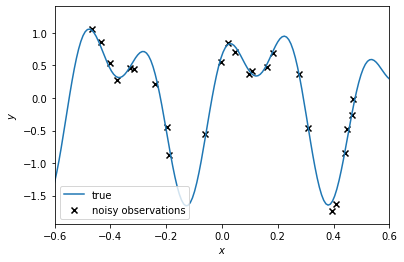

In [4]:
fig, ax = plt.subplots()

ax.plot(X_pred, synthetic_sinusoidal(X_pred), label="true")
ax.scatter(X_train, Y_train, marker='x', color='k',
           label="noisy observations")

ax.legend()

ax.set_xlim(-0.6, 0.6)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

Kernel matrix
-------------



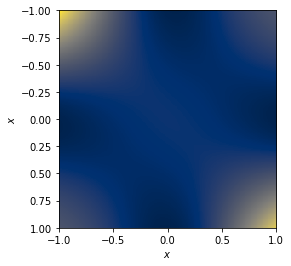

In [5]:
base_kernel = kernel_cls()
kernel = kernels.SchurComplement(
    base_kernel, X_train,
    diag_shift=observation_noise_variance
)

fig, ax = plt.subplots()


ax.imshow(kernel.matrix(X_pred, X_pred), extent=[-1.0, 1.0, 1.0, -1.0],
          cmap="cividis")

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$x$')

plt.show()

Posterior predictive distribution
---------------------------------



In [6]:
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel, index_points=X_pred,
    observation_index_points=X_train,
    observations=Y_train,
    observation_noise_variance=observation_noise_variance,
    jitter=jitter
)

In [7]:
def fill_between_stddev(X_pred, mean_pred, stddev_pred, n=1, ax=None, **kwargs):

    if ax is None:
        ax = plt.gca()

    ax.fill_between(X_pred,
                    mean_pred - n * stddev_pred,
                    mean_pred + n * stddev_pred, **kwargs)

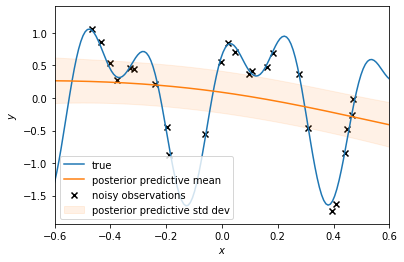

In [8]:
fig, ax = plt.subplots()

ax.plot(X_pred, synthetic_sinusoidal(X_pred), label="true")
ax.scatter(X_train, Y_train, marker='x', color='k',
           label="noisy observations")

ax.plot(X_pred, gprm.mean(), color="tab:orange",
        label="posterior predictive mean")

fill_between_stddev(X_pred.squeeze(),
                    gprm.mean().numpy().squeeze(),
                    gprm.stddev().numpy().squeeze(),
                    alpha=0.1, color="tab:orange",
                    label="posterior predictive std dev", ax=ax)

ax.legend()

ax.set_xlim(-0.6, 0.6)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

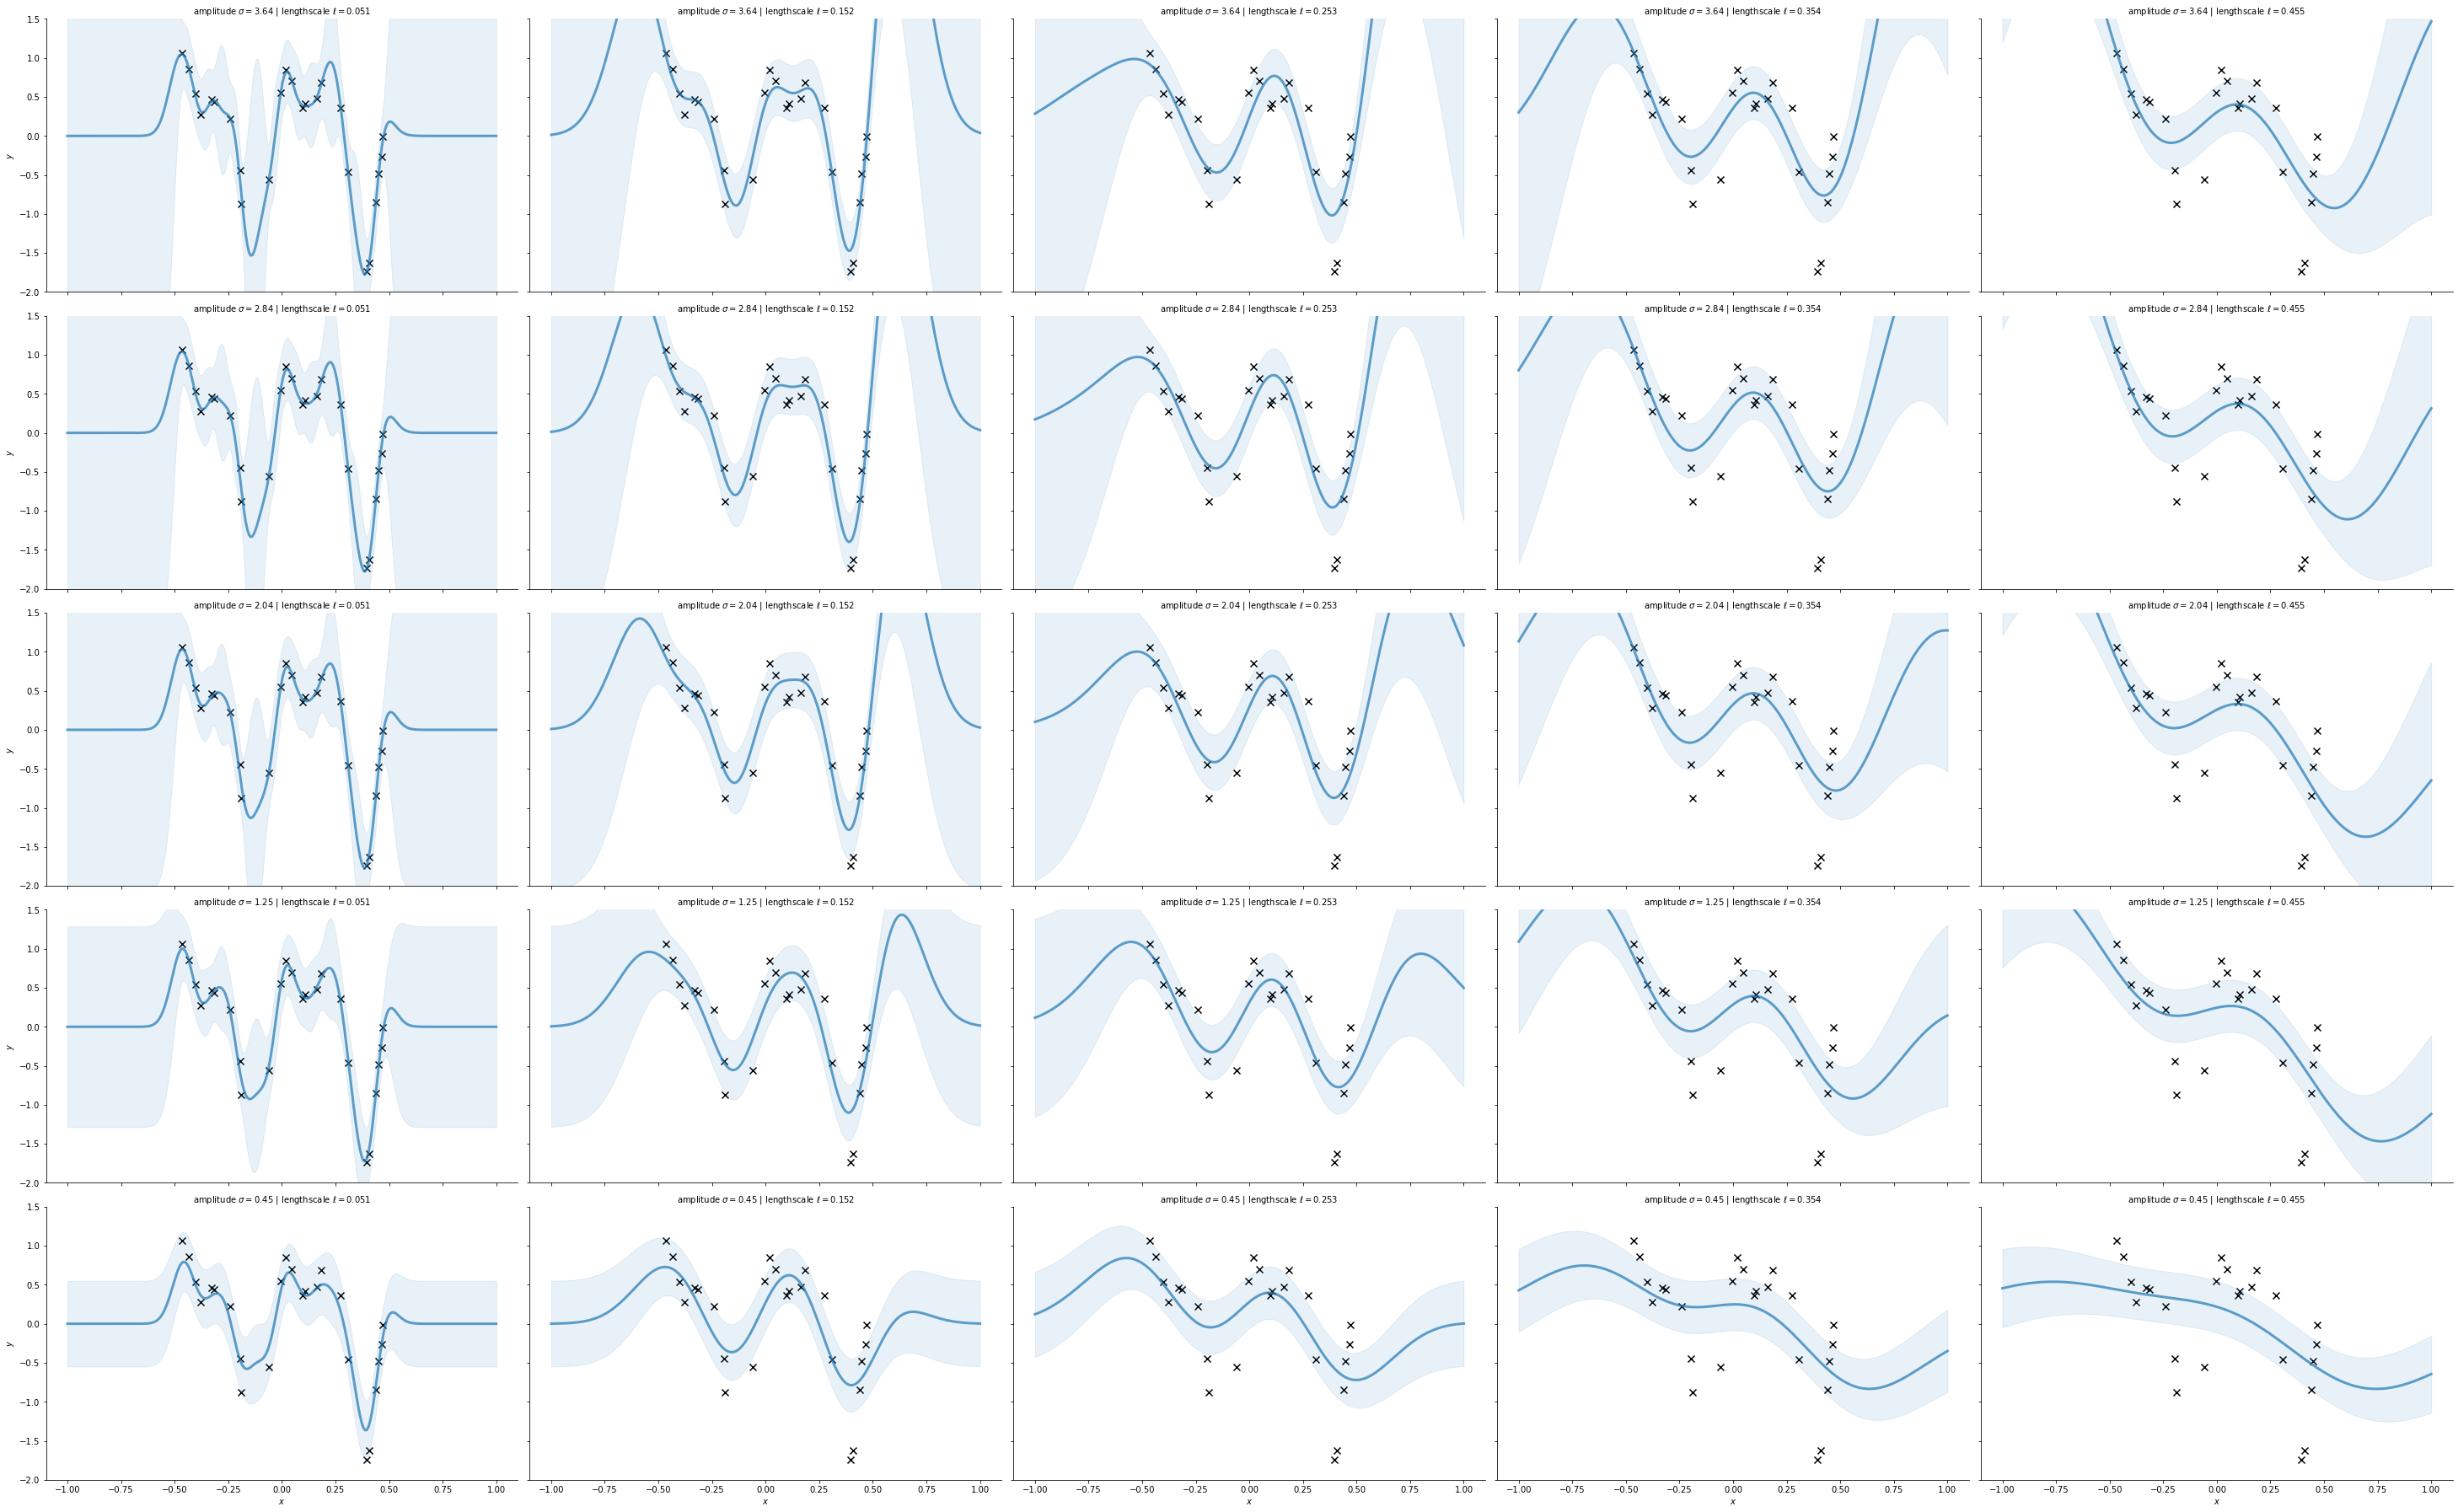

In [9]:
amplitude, length_scale = np.ogrid[5e-2:4.0:100j, 1e-5:5e-1:100j]
amplitude_grid, length_scale_grid = amplitude[10::20], length_scale[..., 10::20]
kernel_grid = kernel_cls(amplitude_grid, length_scale_grid)

gprm_grid = tfd.GaussianProcessRegressionModel(
    kernel=kernel_grid, index_points=X_pred,
    observation_index_points=X_train, observations=Y_train,
    observation_noise_variance=observation_noise_variance,
    jitter=jitter
)

data = dataframe_from_gp_summary(gprm_grid.mean().numpy(),
                                 gprm_grid.stddev().numpy(),
                                 amplitude_grid, length_scale_grid, X_pred) \
    .rename(columns={"length_scale": "lengthscale", "index_point": "x"})


def scatterplot(X, Y, ax=None, *args, **kwargs):

    if ax is None:
        ax = plt.gca()

    ax.scatter(X, Y, s=8.0**2, marker='x', color='k')


g = sns.relplot(x="x", y="mean",
                row="amplitude", col="lengthscale",
                row_order=amplitude_grid[::-1].squeeze(),
                height=5.0, aspect=golden_ratio, kind="line",
                data=data, alpha=0.7, linewidth=3.0)
g.map(scatterplot, X=X_train, Y=Y_train)
g.map(fill_between_stddev, "x", "mean", "stddev", alpha=0.1)
g.set_titles(row_template=r"amplitude $\sigma={{{row_name:.2f}}}$",
             col_template=r"lengthscale $\ell={{{col_name:.3f}}}$")
g.set_axis_labels(r"$x$", r"$y$")
g.set(ylim=(-2.0, 1.5))

Log marginal likelihood (LML)
-----------------------------



In [10]:
kernel = kernel_cls(amplitude, length_scale)

gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=X_train,
    observation_noise_variance=observation_noise_variance
)

nll = - gp.log_prob(Y_train)

3D Surface Plot
^^^^^^^^^^^^^^^



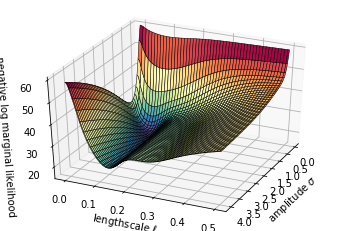

In [11]:
fig, ax = plt.subplots(subplot_kw=dict(projection="3d", azim=25, elev=35))

ax.plot_surface(amplitude, length_scale, nll,  # rstride=1, cstride=1,
                edgecolor='k', linewidth=0.5, cmap="Spectral_r")

ax.set_xlabel(r"amplitude $\sigma$")
ax.set_ylabel(r"lengthscale $\ell$")
ax.set_zlabel("negative log marginal likelihood")

plt.show()

Contour Plot
^^^^^^^^^^^^



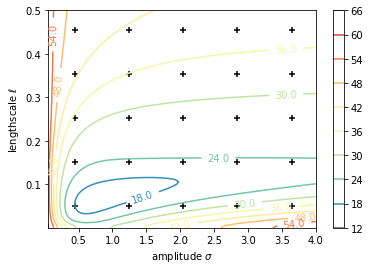

In [12]:
theta = np.dstack(np.broadcast_arrays(amplitude_grid, length_scale_grid)).reshape(-1, 2)

fig, ax = plt.subplots()

ax.scatter(*theta.T, color='k', marker='+')
contours = ax.contour(*np.broadcast_arrays(amplitude, length_scale), nll,
                      cmap="Spectral_r")

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.1f')

ax.set_xlabel(r"amplitude $\sigma$")
ax.set_ylabel(r"lengthscale $\ell$")

plt.show()

In [14]:
kernel_grid

<tfp.math.psd_kernels.ExponentiatedQuadratic 'ExponentiatedQuadratic' batch_shape=(5, 5) feature_ndims=1 dtype=float64>

In [22]:
posterior_grid = kernels.SchurComplement(
    kernel_grid, X_train,
    diag_shift=observation_noise_variance
)
posterior_grid

<tfp.math.psd_kernels.SchurComplement 'SchurComplement/' batch_shape=(5, 5) feature_ndims=1 dtype=float64>

In [23]:
K = posterior_grid.matrix(X_pred, X_pred)
K.shape

TensorShape([5, 5, 256, 256])

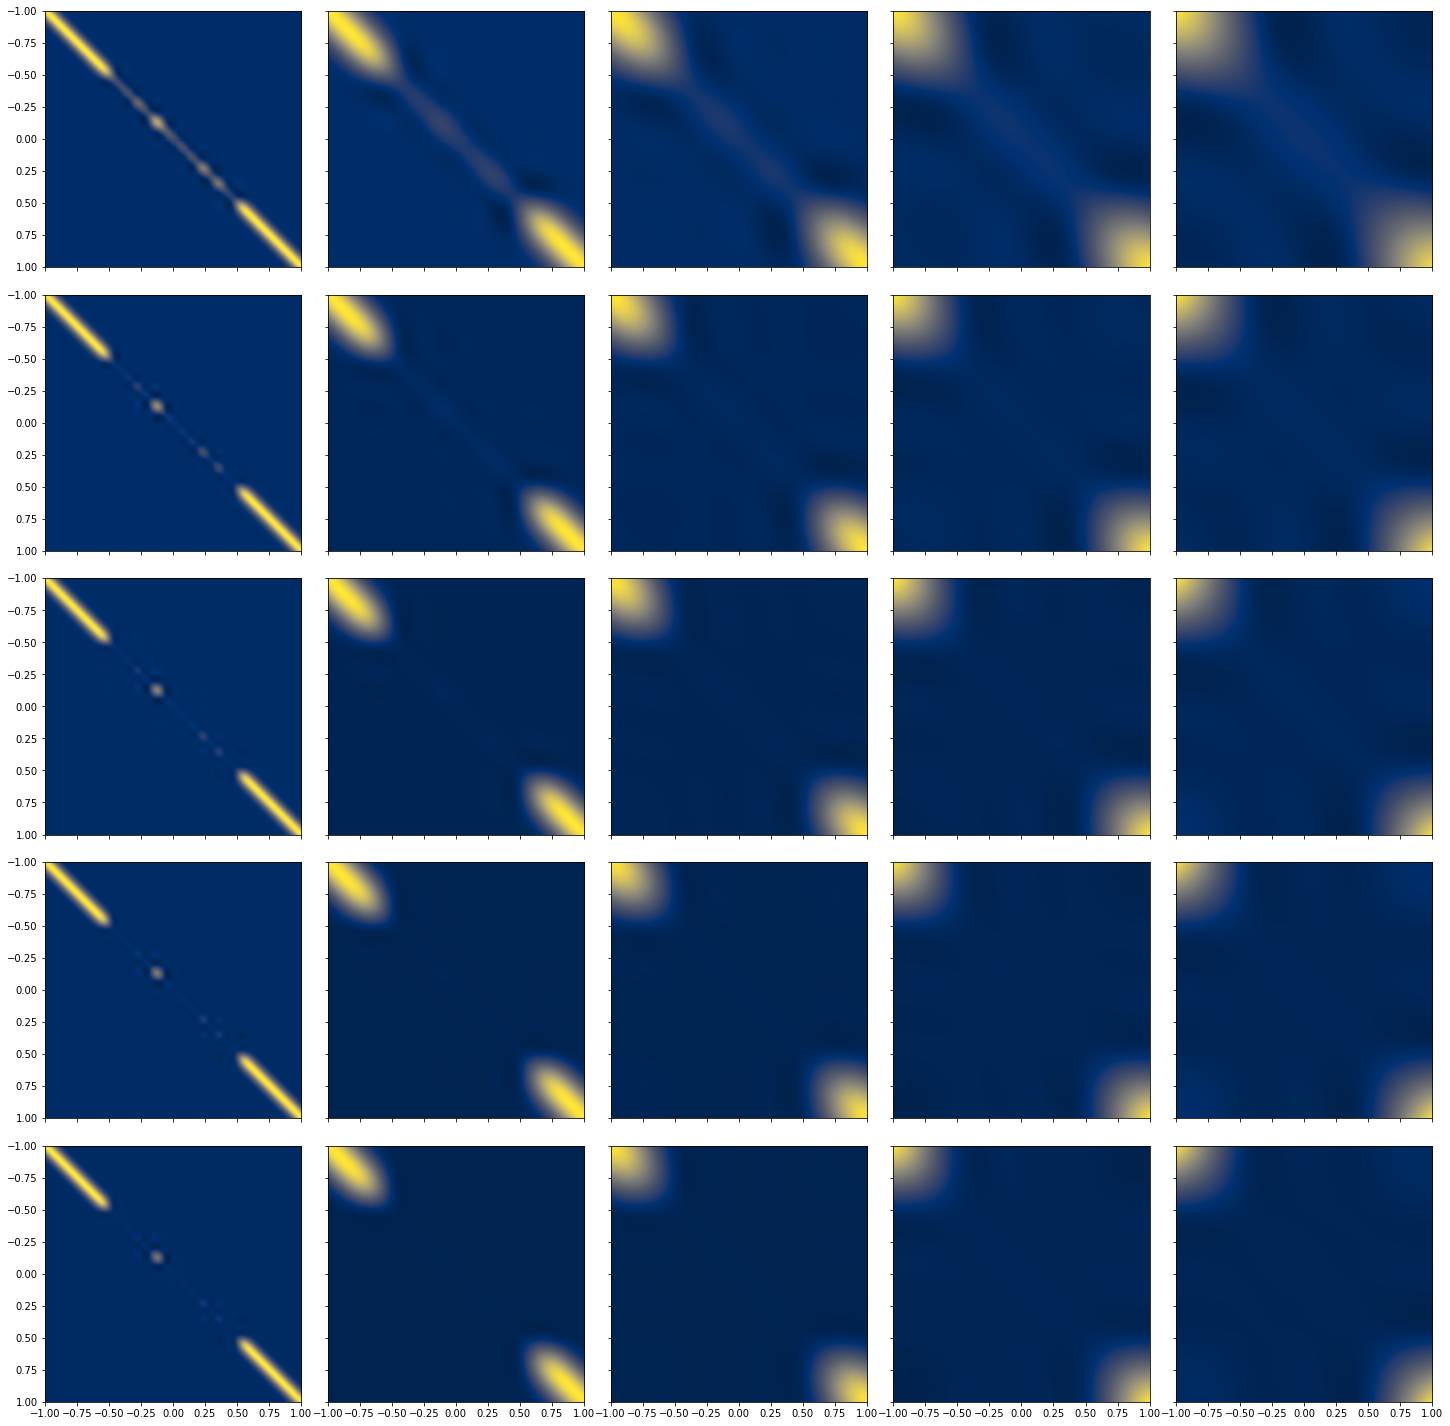

In [30]:
fig, ax_rows = plt.subplots(nrows=posterior_grid.batch_shape[0],
                            ncols=posterior_grid.batch_shape[1],
                            sharex=True, sharey=True, figsize=(20, 20))
fig.tight_layout()

for i, ax_cols in enumerate(ax_rows):
    for j, ax in enumerate(ax_cols):

        ax.imshow(K[i, j], extent=[-1.0, 1.0, 1.0, -1.0],
                  cmap="cividis")

plt.show()